# 시계열 예측

- 시계열 값의 미래 예측 (time series forecasting)
 - 수요예측, 매출예측, 생산/물류/재고 예측, 리스크/장애/이상 예측 등
 
## 접근법
- 자신의 과거 값만 사용하여 미래 값을 예측하는 방법
 - 선형예측, ARIMA, Prophet 등 수리 모델 기반의 단변수 예측 모델이 널리 사용되었다
 - 신호의 패턴에 따라 성능에 한계가 있다
 - 랜덤한 성분은 예측이 안된다 (트렌드, 주기성 만 예측 가능)
- 다양한 관련 외부 신호들을 보고 예측하는 X-y 모델
 - 입력 X에 y의 과거 값들도 포함시킬 수 있다
 - 입력 X에 변형된 신호들을 포함시킬 수 있다 (이동 평균 등)
 - 다양한 종류의 빅데이터를 사용하면 성능이 개선된다
 - 카테고리 변수들을 다루기에 X-y 모델이 유리하다 (선형계열 모델은 카테고리 변수를 표현하는데 한계가 있다)

<img src="https://raw.githubusercontent.com/data-labs/image/main/%E1%84%89%E1%85%B3%E1%84%8F%E1%85%B3%E1%84%85%E1%85%B5%E1%86%AB%E1%84%89%E1%85%A3%E1%86%BA%202021-01-09%20%E1%84%8B%E1%85%A9%E1%84%8C%E1%85%A5%E1%86%AB%2011.16.26.png?raw=1" width=450 align='left'>

## 시계열 예측 방법

- 선형 회귀 (linear regression) 모델: 자신의 과거 샘플의 가중합으로 미래를 예측하는 모델


 > $\hat{y_{n}} = b +a_{1}y_{n-1} + a_{2}y_{n-2} + a_{3}y_{n-3} + ...$
 
 - ARIMA 모델: 선형 모델을 개선하여, 계절성, 트렌드, 시변성 등을 반영한 모델
  - 결측치가 없어야 한다 (계산 오류 발생)
 - 단변수 시계열 예측 도구로 Prophet이 유용하다
 - 단순히 과거의 평균치를 사용하는 baseline 모델도 사용된다
 - 랜덤 포레스트, 부스팅 등 머신러닝 모델이 널리 사용된다.
 - 복잡한 현상을 모델링하기 위해 딥러닝 모델 (MLP, CNN, LSTM 등)을 사용하기도 한다

# 기온 예측
## import

In [169]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'
import matplotlib
matplotlib.rcParams['figure.figsize'] = (8,6)
matplotlib.rcParams.update({'font.size': 15})

In [170]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error,r2_score               

## 날씨 데이터

In [171]:
weather = pd.read_csv('https://raw.githubusercontent.com/StillWork/data/master/new_weather.csv')
print(weather.shape)
weather[:3]

(4018, 4)


,연월일,기온,품질,균질
0,2006/1/1,3.6,8,1
1,2006/1/2,4.0,8,1
2,2006/1/3,3.7,8,1


- 단변수 시계열
 - 날짜 정보를 사용하지 않고 단순히 숫자의 나열로 데이터가 주어지는 경우

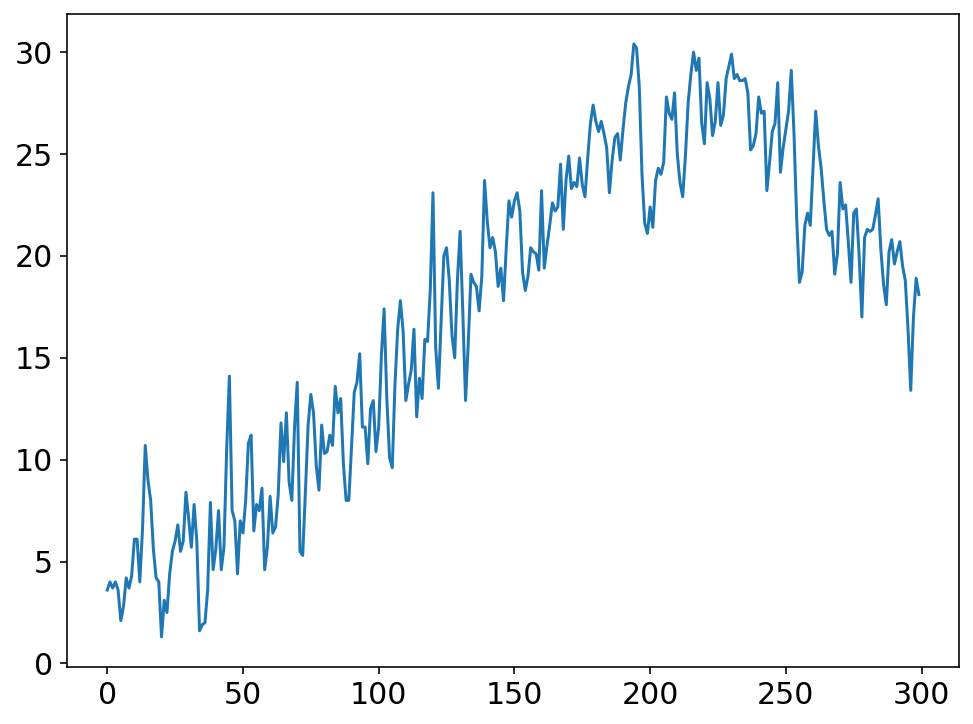

In [172]:
y = weather["기온"].values
plt.plot(y[:300])

In [173]:
y[:20]

array([ 3.6,  4. ,  3.7,  4. ,  3.6,  2.1,  2.8,  4.2,  3.7,  4.3,  6.1,
        6.1,  4. ,  6.6, 10.7,  9. ,  8. ,  5.6,  4.2,  4. ])

## 훈련, 검증 데이터 나누기
- 시계열 데이터는 순서를 유지해야 의미가 있으므로 랜덤하게 섞으면 안된다
- 보통 앞 시간의 데이터로 훈련을 시키고 뒷 부분의 데이터로 검증한다

In [174]:
# 앞부분 75%를 훈련 데이터로, 나머지를 검증 데이터로 나누는 예
ratio = 0.75
cut = int(len(y)*ratio)
train_data = y[:cut]
test_data = y[cut:]
len(y), len(train_data), len(test_data)

(4018, 3013, 1005)

## walk forward 예측
- 내일이 되면 내일 기온을 알 수 있으므로 모레 기온을 예측하는데 내일 데이터를 사용할 수 있다
- 이렇게 미래로 하나씩 이동하면서 데이터를 이용하는 예측을 walk forward 예측이라고 한다
- 시계열 데이터를 테이블 구조로 만들기
 - 시계열 예측에 머신러닝 모델을 쉽게 적용하기 위해서 비정형인 시계열 데이터를 정형 데이터인 테이블 구조로 만들어야 한다
 - 아래는 5개의 시계열 데이터를 보고 6번째 값을 예측하는 경우이며 walk forward 예측을 위한 테이블을 보였다


<img src="https://raw.githubusercontent.com/data-labs/image/main/%E1%84%89%E1%85%B3%E1%84%8F%E1%85%B3%E1%84%85%E1%85%B5%E1%86%AB%E1%84%89%E1%85%A3%E1%86%BA%202021-01-08%20%E1%84%8B%E1%85%A9%E1%84%92%E1%85%AE%203.44.24.png?raw=1" width=600 aligh='left'>

## split_seq()
- 시계열 데이터를 테이블 구조로  표현하는 작업을 수행
 - sequence는 입력 시계열 데이터
 - n_steps는 예측에 사용할 한 행(샘플)의 크기 (위 그림에서 5임)
  - 이를 윈도우 크기라고도 한다

In [175]:
def split_seq(sequence, n_steps):
    x, y = [], []
    for i in range(len(sequence)):
        if i > len(sequence) - (n_steps + 1) : break
        x.append(sequence[i:i+n_steps])
        y.append(sequence[i+n_steps])
    return np.array(x), np.array(y)

In [176]:
# 예: 과거 5개의 샘플을 보고 다음 값을 예측하기 위한 훈련데이터 X, y 생성
sequence = [1,2,3,4,5,6,7,8,9,10,11,12,13]
x_train, y_train = split_seq(sequence, 5)
x_train, y_train

(array([[ 1,  2,  3,  4,  5],
        [ 2,  3,  4,  5,  6],
        [ 3,  4,  5,  6,  7],
        [ 4,  5,  6,  7,  8],
        [ 5,  6,  7,  8,  9],
        [ 6,  7,  8,  9, 10],
        [ 7,  8,  9, 10, 11],
        [ 8,  9, 10, 11, 12]]),
 array([ 6,  7,  8,  9, 10, 11, 12, 13]))

## (연습) 윈도우가 7일 경우의 split_seq()를 수행해보시오

In [227]:
# (풀이)



# 선형 예측 모델
- Linear Prediction
- 자신의 과거 샘플의 가중합으로 미래값을 예측하는 모델
- 선형 회귀 (linear regression) 모델을 사용하면 된다

 > $\hat{y_{n}} = b +a_{1}y_{n-1} + a_{2}y_{n-2} + a_{3}y_{n-3} + ...$
 


In [178]:
# 과거 며칠간의 데이터를 미래 예측에 사용할 것인지 지정 (윈도우 크기)
n_steps = 10

x_train, y_train = split_seq(train_data, n_steps)
x_test, y_test = split_seq(test_data, n_steps)
model = LinearRegression()
model.fit(x_train, y_train) 
model.score(x_test, y_test).round(4) # R2 값

0.936

## 모델 성능 평가
- 회귀 모델의 성능을 평가하는 척도로 기본적으로 R-Squared를 사용하며 MAE, RMSE 등을 참고로 본다
 - MAE: mean absolute error  
 - MSE: mean squared error    
 - RMSE: root MSE  

$MAE = $$1\over{N}$$ \sum |y_{i} - \hat{y}|$

$MSE = $$1\over{N}$$ \sum (y_{i} - \hat{y})^{2}$

$RMSE = \sqrt{MSE}$

$R^{2} = 1$-$\sum(y_{i}-\hat{y})^{2}\over{\sum(y_{i}-\bar{y})^{2}}$ $= 1$-$MSE\over{Variance}$  
 >  $y$ :  실제값  
 >  $\hat{y}$ :  예측치  
 >  $\bar{y}$ :  평균치
 
 ### R-Squared
- 회귀 성능의 기본적인 평가 지표
- MSE를 분산으로 정규화한 값을 사용한다
- R-sqaured 값은 1에 가까울수록 완벽한 예측을 수행한 것이고, 0 근처이면 오차 평균치가 표준편차 정도인 경우이다

In [179]:
def show_reg_result(y_test,y_pred):
    print("Max Error: ", 
      round(np.abs(y_test - y_pred).max(),3))
    print("Mean Absolute Error: ", 
      round(np.abs(y_test-y_pred).mean(),3))
    print("Root Mean Squared Error: ", 
      mean_squared_error(y_test,y_pred, squared=False).round(3))
    print("R-Squared: ", 
      r2_score(y_test, y_pred).round(3))

In [180]:
def plot_reg_result(y_test, y_pred, N=50):
    y_t=y_test.ravel()
    y_p=y_pred.ravel()
    plt.plot(y_t[:N], 'r.-', label='y_test')
    plt.plot(y_p[:N], 'b.--', label='y_pred')
    plt.legend()
    plt.show()
    plt.title("Residue Plot")
    plt.scatter(y_t, y_t - y_p, s=5)

In [181]:
y_pred = model.predict(x_test)
show_reg_result(y_test, y_pred)

Max Error:  8.614
Mean Absolute Error:  1.498
Root Mean Squared Error:  1.921
R-Squared:  0.936


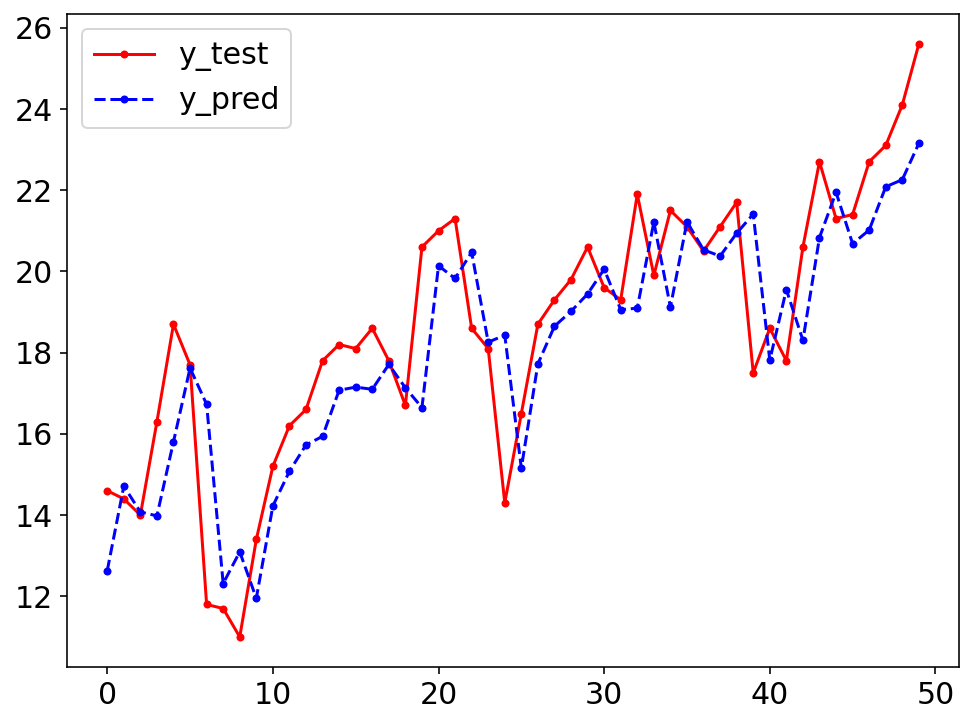

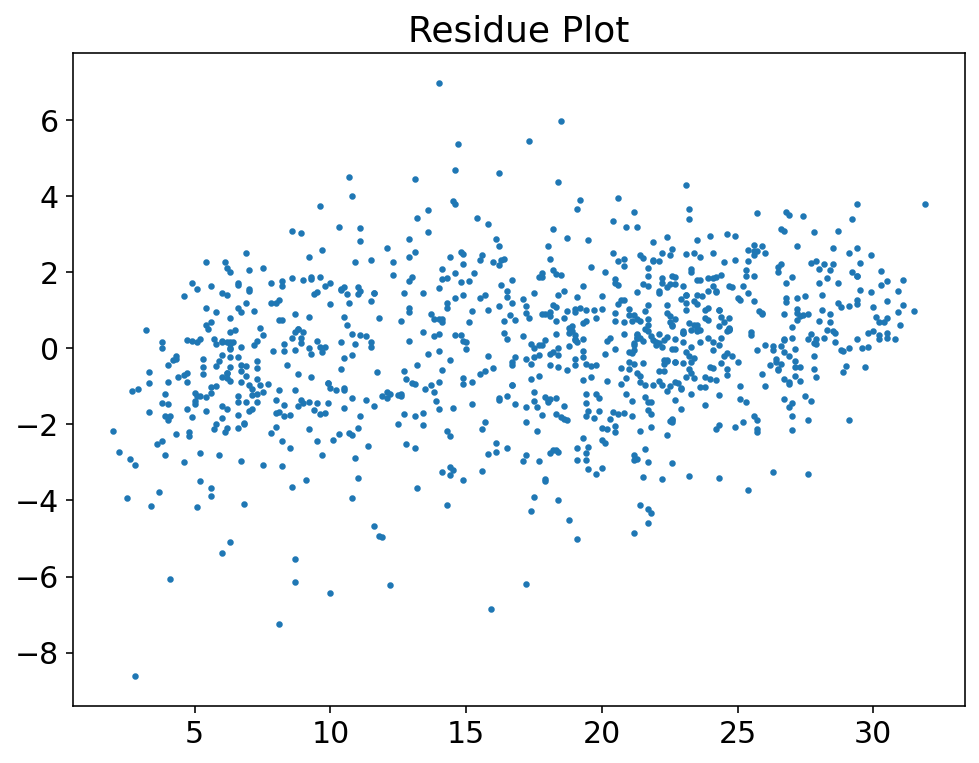

In [182]:
plot_reg_result(y_test, y_pred)

## (연습) 선형 예측 모델에서 과거 5일 및 15일을 사용할 때 각각의 성능을 구하시오

In [228]:
# (풀이)



## (연습) 선형 예측 모델에서 과거 몇 개를 예측에 사용하면 성능이 가장 좋은지 최적 값을 찾으시오

- 힌트 n_steps 값을 바꾸어 본다 (1 ~ 180 일)
- 가장 성능이 좋을 때의 회귀 성능을 확인하시오

In [229]:
# (풀이)



# 베이스라인 모델
- 간단히 만들 수 있는 모델로 나이브 모델이라고도 한다
- 최소한 이것보다는 성능이 개선된 모델을 만들어야 한다
- 종류
 - persistent 모델: 직전의 샘플 값으로 다음 값을 예측
 - 이동 평균 모델: 직전의 N개 샘플의 평균으로 예측 (최근 값의 비중을 크게 반영하는 지수형 가중 평균을 사용하기도 한다, ema:exponential moving average)
 - 직전 값들이 아니라 주기적인 일정 간격으로 샘플을 취하기도 한다

## persistent 모델

In [188]:
# 현재 값 하나로 다음 값을 예측하는 경우
y_pred, y_test = split_seq(test_data, 1) 

In [189]:
y_pred[:5], y_test[:5]

(array([[15.2],
        [13.8],
        [15.3],
        [11.4],
        [ 9. ]]),
 array([13.8, 15.3, 11.4,  9. , 11.4]))

In [190]:
show_reg_result(y_test, y_pred)

Max Error:  29.9
Mean Absolute Error:  8.695
Root Mean Squared Error:  2.051
R-Squared:  0.927


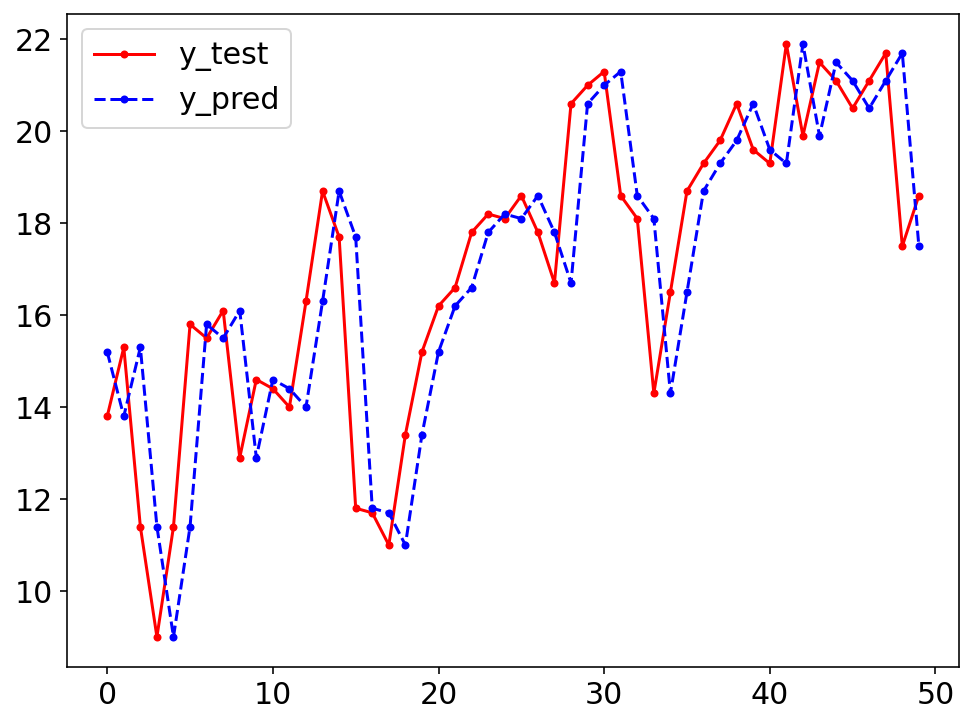

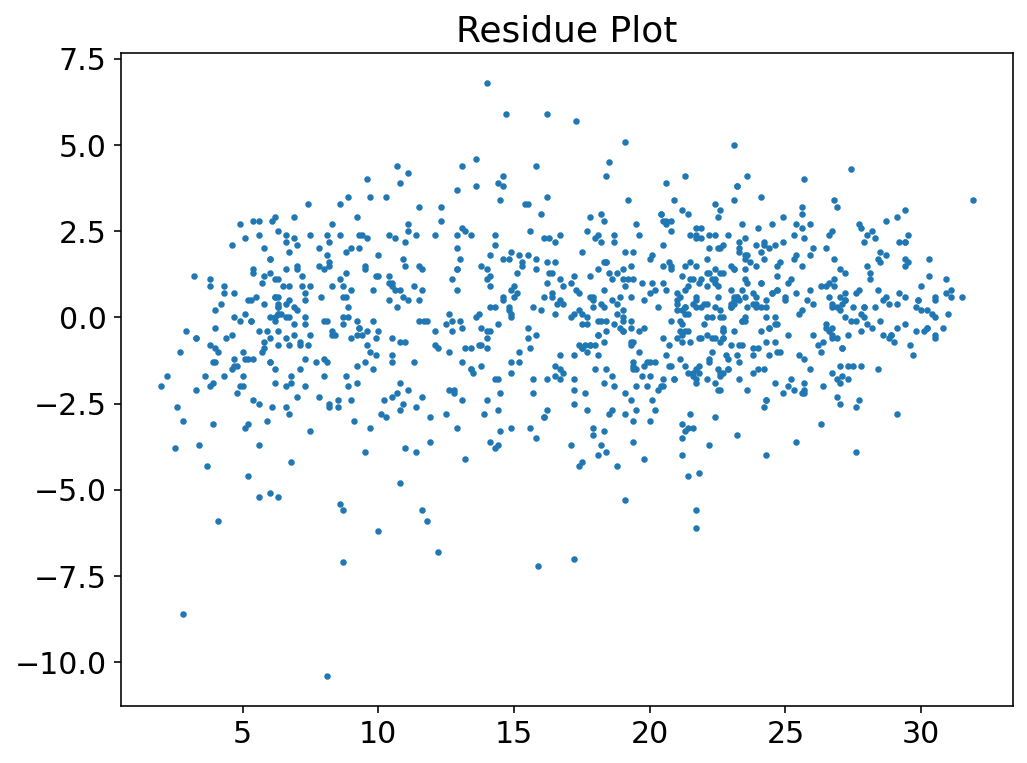

In [191]:
plot_reg_result(y_test, y_pred)

## 과거의 평균치로 예측하는 경우

In [192]:
# 입력 데이터의 평균치를 리턴하는 함수
# 행단위 평균을 구하기 위해서 axis=1 지정
def average_model(seq):
    return np.array(seq).mean(axis=1)

In [193]:
# 동작 확인 (행별로 4개 데이터의 평균을 얻기)
z = np.arange(24).reshape(6,4)
print(z)
average_model(z)

[[ 0  1  2  3]
 [ 4  5  6  7]
 [ 8  9 10 11]
 [12 13 14 15]
 [16 17 18 19]
 [20 21 22 23]]


array([ 1.5,  5.5,  9.5, 13.5, 17.5, 21.5])

In [194]:
# 과거 몇개(N)의 평균을 사용할 때 성능이 가장 좋은지 확인
N = 20
result = []
for average in range(1,N+1): 
    x_test, y_test = split_seq(test_data, average)
    y_pred = average_model(x_test)
    result.append((average, r2_score(y_test, y_pred).round(4)))
result 

[(1, 0.9266),
 (2, 0.9166),
 (3, 0.9113),
 (4, 0.9074),
 (5, 0.9037),
 (6, 0.901),
 (7, 0.8991),
 (8, 0.8982),
 (9, 0.8971),
 (10, 0.896),
 (11, 0.8948),
 (12, 0.8932),
 (13, 0.8913),
 (14, 0.8897),
 (15, 0.888),
 (16, 0.8861),
 (17, 0.8841),
 (18, 0.8812),
 (19, 0.8778),
 (20, 0.8741)]

<AxesSubplot:xlabel='window'>

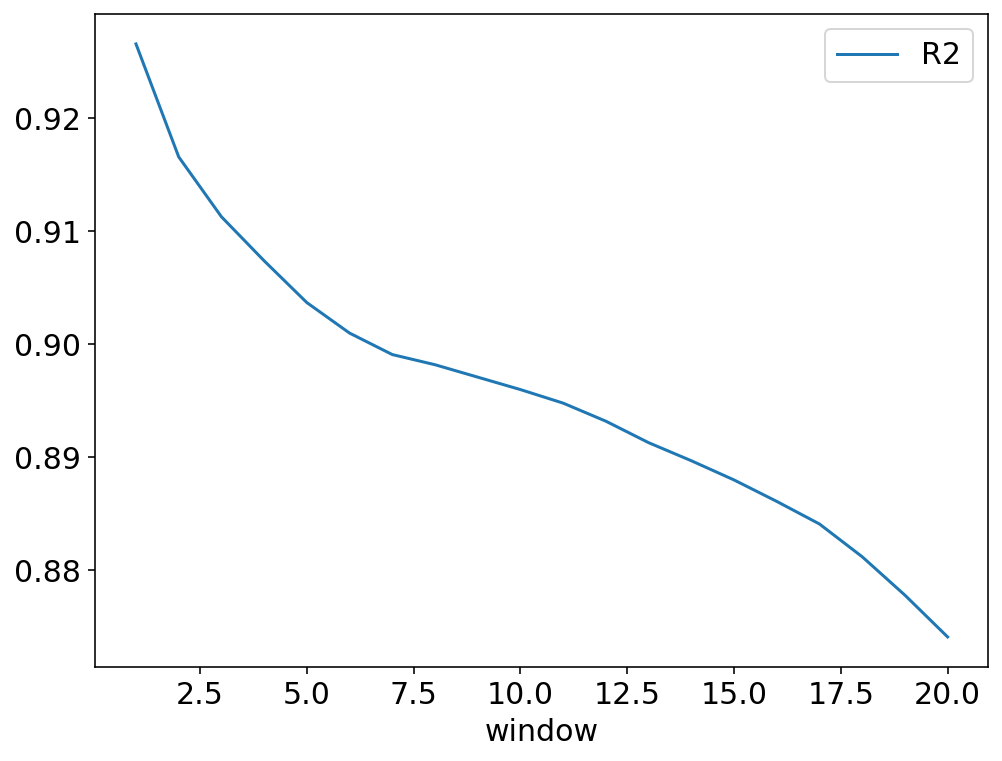

In [195]:
df_result = pd.DataFrame(result, columns=['window','R2'])
df_result.set_index('window', drop=True).plot()

## (연습) 최적의 윈도우 값을 찾는 위의 예에서 결과를 리스트가 아니라 딕셔너리에 담아보시오

- 딕셔너리에 값을 담을 때는 key를 인자로 사용하고 값을 배정하면 된다
- 결과를 그래프로 그려보시오

In [230]:
# (풀이)



# 에너지 사용 예측

## 데이터

- 한 가정의 시간단위 에너지 사용 데이터를 이용해 시계열 예측을 수행하겠다

In [200]:
power = pd.read_csv("https://raw.githubusercontent.com/StillWork/data/master/energy_3years.csv",
                 parse_dates=['timestamp'])
power.set_index("timestamp", inplace=True)

print(power.shape)
power[:3]

(26304, 2)


,load,temp
timestamp,,
2012-01-01 00:00:00,2698.0,32.000000
2012-01-01 01:00:00,2558.0,32.666667
2012-01-01 02:00:00,2444.0,30.000000


<AxesSubplot:xlabel='timestamp'>

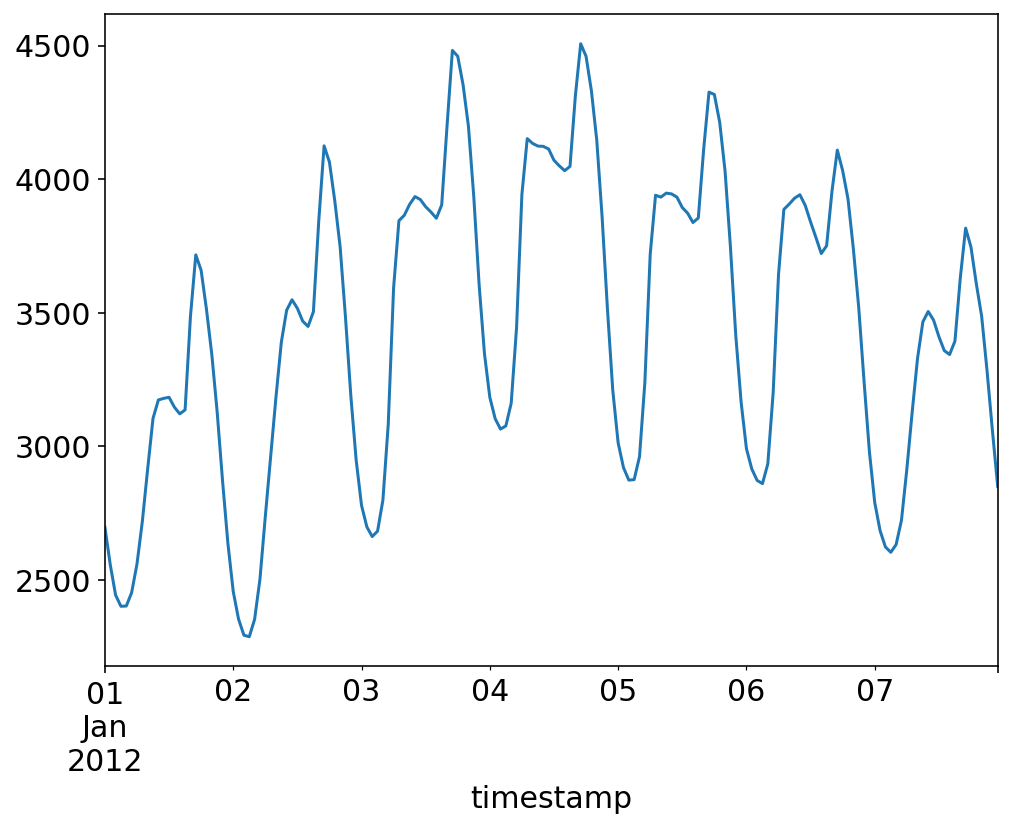

In [201]:
power.load[:24*7].plot()

- 하루 단위 데이터로 다운 샘플링 하는 방법
- 하루의 전력 사용량 합계를 사용하겠다

In [202]:
df_down = power.resample('D').sum()
print(df_down.shape)
df_down[:3]

(1096, 2)


,load,temp
timestamp,,
2012-01-01,71562.0,906.333333
2012-01-02,76841.0,897.666667
2012-01-03,87887.0,418.333333


- 기온은 합이 아니라 평균을 사용하겠다.

In [203]:
df_down['temp'] = power.temp.resample('D').mean()
df_down[:5]

,load,temp
timestamp,,
2012-01-01,71562.0,37.763889
2012-01-02,76841.0,37.402778
2012-01-03,87887.0,17.430556
2012-01-04,92168.0,13.111111
2012-01-05,88096.0,24.875000


## 단변수 시계열 예측 (load)

In [204]:
y = df_down.load
ratio = 0.75
cut = int(len(y)*ratio)
train_data = y[:cut]
test_data = y[cut:]
len(y), len(train_data), len(test_data)

(1096, 822, 274)

### 선형 예측 모델

max R2:  0.797


Text(0.5, 1.0, 'R2 vs window size (Linear Model)')

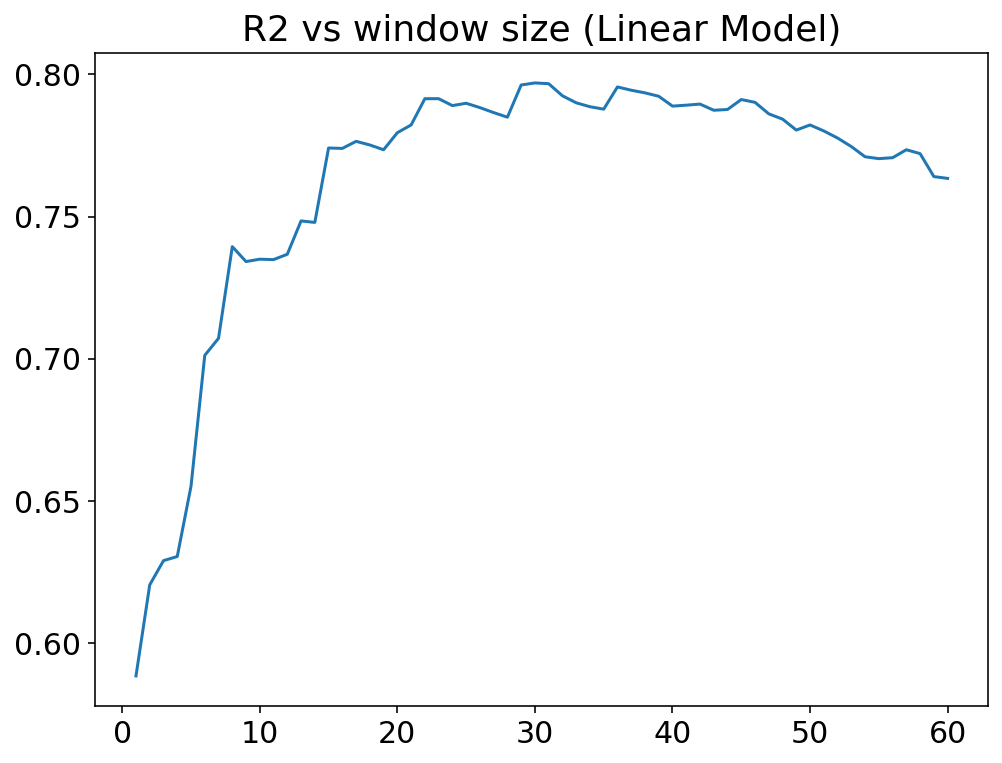

In [205]:
N = 60
model = LinearRegression()
result = []

for n_steps in range(1,N+1): 
    x_train, y_train = split_seq(train_data, n_steps)
    x_test, y_test = split_seq(test_data, n_steps)
    model.fit(x_train, y_train) 
    result.append((n_steps, model.score(x_test, y_test)))
                  
result = np.array(result)
print("max R2: ", result[:,1].max().round(3))
plt.plot(result[:,0], result[:,1])
plt.title("R2 vs window size (Linear Model)")

- 최적의 윈도우 선택

In [206]:
x_train, y_train = split_seq(train_data, 30)
x_test, y_test = split_seq(test_data, 30)
model.fit(x_train, y_train) 
y_pred = model.predict(x_test)
show_reg_result(y_test, y_pred)

Max Error:  14205.837
Mean Absolute Error:  2220.282
Root Mean Squared Error:  3031.463
R-Squared:  0.797


- 모델, 데이터, 윈도우 크기를 주면 시계열 분석을 수행하는 함수 정의

In [207]:
def split_seq_fit(model, train_data, test_data, n_steps):
    x_train, y_train = split_seq(train_data, n_steps)
    x_test, y_test = split_seq(test_data, n_steps)
    model.fit(x_train, y_train) 
    return model.score(x_test, y_test)

### 랜덤 포레스트 모델을 사용하는 경우

max R2:  0.738


Text(0.5, 1.0, 'R2 vs window size(Random Forest)')

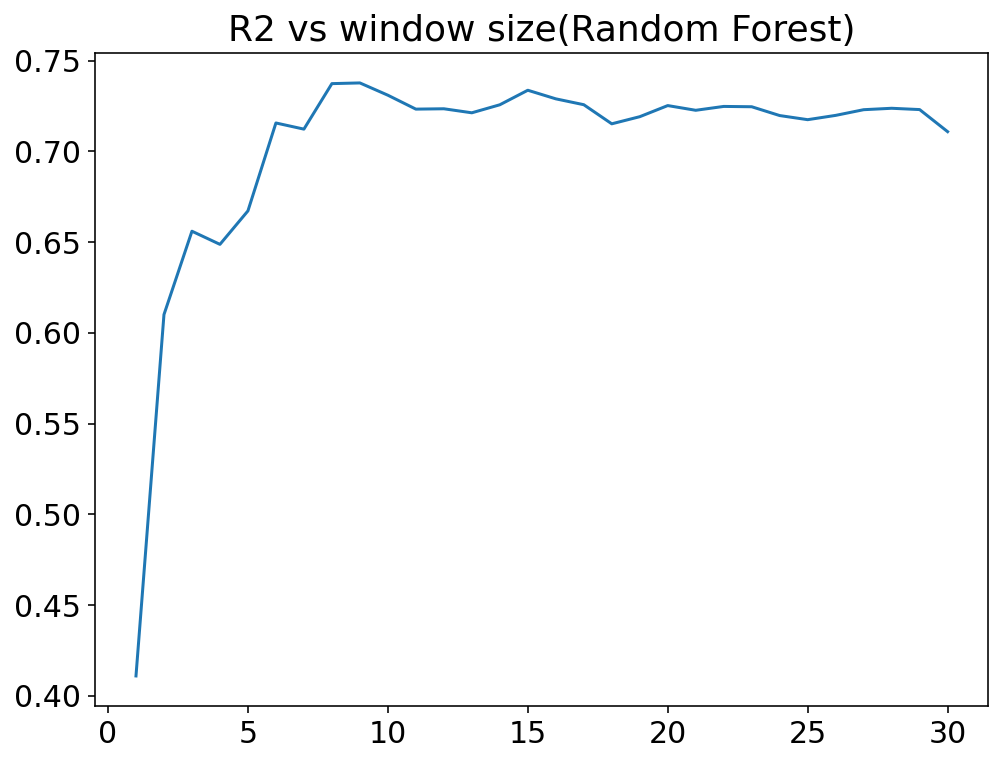

In [208]:
from sklearn.ensemble import RandomForestRegressor
rfr = RandomForestRegressor()
N = 30
result = []

for n_steps in range(1,N+1): 
    r2 = split_seq_fit(rfr, train_data, test_data, n_steps)
    result.append((n_steps, r2))
                  
result = np.array(result)
print("max R2: ", result[:,1].max().round(3))

plt.plot(result[:,0], result[:,1])
plt.title("R2 vs window size(Random Forest)")

### (연습) LightGBM 모델을 사용하고 윈도우 크기를 바꾸어 성능을 비교하시오

- lightgbm을 먼저 설치해야 한다 (!pip install lightgbm)
- 모델로 LGBMRegressor()를 사용한다

In [231]:
# (풀이)



## 다중변수 예측

- 자신의 과거값을 예측에 사용하되 다양한 특성을 같이 사용하는 방법

### 특성 추가

- 과거 15일치 전력사용량과 5일간의 날씨를 입력으로 사용하는 경우
- 미래 3일간 전력사용량을 예측

In [231]:
df_down[:17]

,load,temp
timestamp,,
2012-01-01,71562.0,37.763889
2012-01-02,76841.0,37.402778
2012-01-03,87887.0,17.430556
2012-01-04,92168.0,13.111111
2012-01-05,88096.0,24.875000
2012-01-06,85591.0,25.902778
2012-01-07,76869.0,31.652778
2012-01-08,77767.0,30.000000
2012-01-09,85818.0,25.277778


In [210]:
df = df_down.copy()

df['load-1'] = df.load.shift(1)
df[:5]

,load,temp,load-1
timestamp,,,
2012-01-01,71562.0,37.763889,NaN
2012-01-02,76841.0,37.402778,71562.0
2012-01-03,87887.0,17.430556,76841.0
2012-01-04,92168.0,13.111111,87887.0
2012-01-05,88096.0,24.875000,92168.0


- 과거 15일간의 전력사용 데이터 커럼에 추가

In [212]:
N_load = 15
for i in range (1,N_load + 1):
    df['load-'+str(i)]=df.load.shift(i)
df[:10]

,load,temp,load-1,load-2,load-3,load-4,load-5,load-6,load-7,load-8,load-9,load-10,load-11,load-12,load-13,load-14,load-15
timestamp,,,,,,,,,,,,,,,,,
2012-01-01,71562.0,37.763889,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2012-01-02,76841.0,37.402778,71562.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2012-01-03,87887.0,17.430556,76841.0,71562.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2012-01-04,92168.0,13.111111,87887.0,76841.0,71562.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2012-01-05,88096.0,24.875000,92168.0,87887.0,76841.0,71562.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2012-01-06,85591.0,25.902778,88096.0,92168.0,87887.0,76841.0,71562.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2012-01-07,76869.0,31.652778,85591.0,88096.0,92168.0,87887.0,76841.0,71562.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2012-01-08,77767.0,30.000000,76869.0,85591.0,88096.0,92168.0,87887.0,76841.0,71562.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2012-01-09,85818.0,25.277778,77767.0,76869.0,85591.0,88096.0,92168.0,87887.0,76841.0,71562.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


-  과거 5일의 날씨 데이터 추가

In [213]:
N_temp = 5
for i in range (1,N_temp+1):
    df['temp-'+str(i)]=df.temp.shift(i)

- 목적 변수 추가: 미래 3일까지 예측하려고 한다

In [214]:
df['y+1'] = df.load.shift(-1)
df['y+2'] = df.load.shift(-2)
df['y+3'] = df.load.shift(-3)
df[:20]

,load,temp,load-1,load-2,load-3,load-4,load-5,load-6,load-7,load-8,...,load-14,load-15,temp-1,temp-2,temp-3,temp-4,temp-5,y+1,y+2,y+3
timestamp,,,,,,,,,,,,,,,,,,,,,
2012-01-01,71562.0,37.763889,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,76841.0,87887.0,92168.0
2012-01-02,76841.0,37.402778,71562.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,37.763889,NaN,NaN,NaN,NaN,87887.0,92168.0,88096.0
2012-01-03,87887.0,17.430556,76841.0,71562.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,37.402778,37.763889,NaN,NaN,NaN,92168.0,88096.0,85591.0
2012-01-04,92168.0,13.111111,87887.0,76841.0,71562.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,17.430556,37.402778,37.763889,NaN,NaN,88096.0,85591.0,76869.0
2012-01-05,88096.0,24.875000,92168.0,87887.0,76841.0,71562.0,NaN,NaN,NaN,NaN,...,NaN,NaN,13.111111,17.430556,37.402778,37.763889,NaN,85591.0,76869.0,77767.0
2012-01-06,85591.0,25.902778,88096.0,92168.0,87887.0,76841.0,71562.0,NaN,NaN,NaN,...,NaN,NaN,24.875000,13.111111,17.430556,37.402778,37.763889,76869.0,77767.0,85818.0
2012-01-07,76869.0,31.652778,85591.0,88096.0,92168.0,87887.0,76841.0,71562.0,NaN,NaN,...,NaN,NaN,25.902778,24.875000,13.111111,17.430556,37.402778,77767.0,85818.0,85158.0
2012-01-08,77767.0,30.000000,76869.0,85591.0,88096.0,92168.0,87887.0,76841.0,71562.0,NaN,...,NaN,NaN,31.652778,25.902778,24.875000,13.111111,17.430556,85818.0,85158.0,85021.0
2012-01-09,85818.0,25.277778,77767.0,76869.0,85591.0,88096.0,92168.0,87887.0,76841.0,71562.0,...,NaN,NaN,30.000000,31.652778,25.902778,24.875000,13.111111,85158.0,85021.0,84824.0


In [67]:
df[-5:]

,load,temp,temp-1,y+1,y+2,y+3,load-1,load-2,load-3,load-4,...,load-6,load-7,load-8,load-9,load-10,load-11,load-12,load-13,load-14,load-15
timestamp,,,,,,,,,,,,,,,,,,,,,
2014-12-27,73845.0,38.666667,41.569444,74678.0,84486.0,88810.0,74155.0,69507.0,77368.0,83002.0,...,82822.0,83313.0,85838.0,83868.0,82910.0,84688.0,83830.0,78456.0,80554.0,83648.0
2014-12-28,74678.0,43.125000,38.666667,84486.0,88810.0,89246.0,73845.0,74155.0,69507.0,77368.0,...,84443.0,82822.0,83313.0,85838.0,83868.0,82910.0,84688.0,83830.0,78456.0,80554.0
2014-12-29,84486.0,30.305556,43.125000,88810.0,89246.0,NaN,74678.0,73845.0,74155.0,69507.0,...,83002.0,84443.0,82822.0,83313.0,85838.0,83868.0,82910.0,84688.0,83830.0,78456.0
2014-12-30,88810.0,18.347222,30.305556,89246.0,NaN,NaN,84486.0,74678.0,73845.0,74155.0,...,77368.0,83002.0,84443.0,82822.0,83313.0,85838.0,83868.0,82910.0,84688.0,83830.0
2014-12-31,89246.0,17.375000,18.347222,NaN,NaN,NaN,88810.0,84486.0,74678.0,73845.0,...,69507.0,77368.0,83002.0,84443.0,82822.0,83313.0,85838.0,83868.0,82910.0,84688.0


- 결측치 제거
- 일부 데이터가 학습에 사용되지 못한다 (샘플수가 적을 때 주의)

In [215]:
df = df.dropna()
print(df.shape)
df[:20]

(1078, 25)


,load,temp,load-1,load-2,load-3,load-4,load-5,load-6,load-7,load-8,...,load-14,load-15,temp-1,temp-2,temp-3,temp-4,temp-5,y+1,y+2,y+3
timestamp,,,,,,,,,,,,,,,,,,,,,
2012-01-16,91228.0,12.180556,88319.0,84300.0,83503.0,84824.0,85021.0,85158.0,85818.0,77767.0,...,76841.0,71562.0,3.527778,19.055556,30.375000,29.361111,24.916667,83799.0,84192.0,90190.0
2012-01-17,83799.0,33.138889,91228.0,88319.0,84300.0,83503.0,84824.0,85021.0,85158.0,85818.0,...,87887.0,76841.0,12.180556,3.527778,19.055556,30.375000,29.361111,84192.0,90190.0,87129.0
2012-01-18,84192.0,28.263889,83799.0,91228.0,88319.0,84300.0,83503.0,84824.0,85021.0,85158.0,...,92168.0,87887.0,33.138889,12.180556,3.527778,19.055556,30.375000,90190.0,87129.0,85869.0
2012-01-19,90190.0,16.986111,84192.0,83799.0,91228.0,88319.0,84300.0,83503.0,84824.0,85021.0,...,88096.0,92168.0,28.263889,33.138889,12.180556,3.527778,19.055556,87129.0,85869.0,82897.0
2012-01-20,87129.0,19.791667,90190.0,84192.0,83799.0,91228.0,88319.0,84300.0,83503.0,84824.0,...,85591.0,88096.0,16.986111,28.263889,33.138889,12.180556,3.527778,85869.0,82897.0,84221.0
2012-01-21,85869.0,12.027778,87129.0,90190.0,84192.0,83799.0,91228.0,88319.0,84300.0,83503.0,...,76869.0,85591.0,19.791667,16.986111,28.263889,33.138889,12.180556,82897.0,84221.0,79804.0
2012-01-22,82897.0,11.888889,85869.0,87129.0,90190.0,84192.0,83799.0,91228.0,88319.0,84300.0,...,77767.0,76869.0,12.027778,19.791667,16.986111,28.263889,33.138889,84221.0,79804.0,81543.0
2012-01-23,84221.0,30.875000,82897.0,85869.0,87129.0,90190.0,84192.0,83799.0,91228.0,88319.0,...,85818.0,77767.0,11.888889,12.027778,19.791667,16.986111,28.263889,79804.0,81543.0,81906.0
2012-01-24,79804.0,40.305556,84221.0,82897.0,85869.0,87129.0,90190.0,84192.0,83799.0,91228.0,...,85158.0,85818.0,30.875000,11.888889,12.027778,19.791667,16.986111,81543.0,81906.0,81654.0


- 모든 특성을 사용하고 내일의 전력 사용량을 예측하는 경우

In [216]:
X = df[df.columns.difference(['y+1', 'y+2', 'y+3'])]
y = df['y+1']
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                shuffle=False, random_state=9)

In [217]:
X_train[:5]

,load,load-1,load-10,load-11,load-12,load-13,load-14,load-15,load-2,load-3,...,load-6,load-7,load-8,load-9,temp,temp-1,temp-2,temp-3,temp-4,temp-5
timestamp,,,,,,,,,,,,,,,,,,,,,
2012-01-16,91228.0,88319.0,85591.0,88096.0,92168.0,87887.0,76841.0,71562.0,84300.0,83503.0,...,85158.0,85818.0,77767.0,76869.0,12.180556,3.527778,19.055556,30.375000,29.361111,24.916667
2012-01-17,83799.0,91228.0,76869.0,85591.0,88096.0,92168.0,87887.0,76841.0,88319.0,84300.0,...,85021.0,85158.0,85818.0,77767.0,33.138889,12.180556,3.527778,19.055556,30.375000,29.361111
2012-01-18,84192.0,83799.0,77767.0,76869.0,85591.0,88096.0,92168.0,87887.0,91228.0,88319.0,...,84824.0,85021.0,85158.0,85818.0,28.263889,33.138889,12.180556,3.527778,19.055556,30.375000
2012-01-19,90190.0,84192.0,85818.0,77767.0,76869.0,85591.0,88096.0,92168.0,83799.0,91228.0,...,83503.0,84824.0,85021.0,85158.0,16.986111,28.263889,33.138889,12.180556,3.527778,19.055556
2012-01-20,87129.0,90190.0,85158.0,85818.0,77767.0,76869.0,85591.0,88096.0,84192.0,83799.0,...,84300.0,83503.0,84824.0,85021.0,19.791667,16.986111,28.263889,33.138889,12.180556,3.527778


In [218]:
y[:5]

timestamp
2012-01-16    83799.0
2012-01-17    84192.0
2012-01-18    90190.0
2012-01-19    87129.0
2012-01-20    85869.0
Freq: D, Name: y+1, dtype: float64

In [219]:
lin = LinearRegression()
lin.fit(X_train, y_train) 
lin.score(X_test, y_test).round(4) 

0.7707

In [222]:
y_pred = lin.predict(X_test)
show_reg_result(y_test, y_pred)

Max Error:  13649.159
Mean Absolute Error:  2270.324
Root Mean Squared Error:  3121.983
R-Squared:  0.771


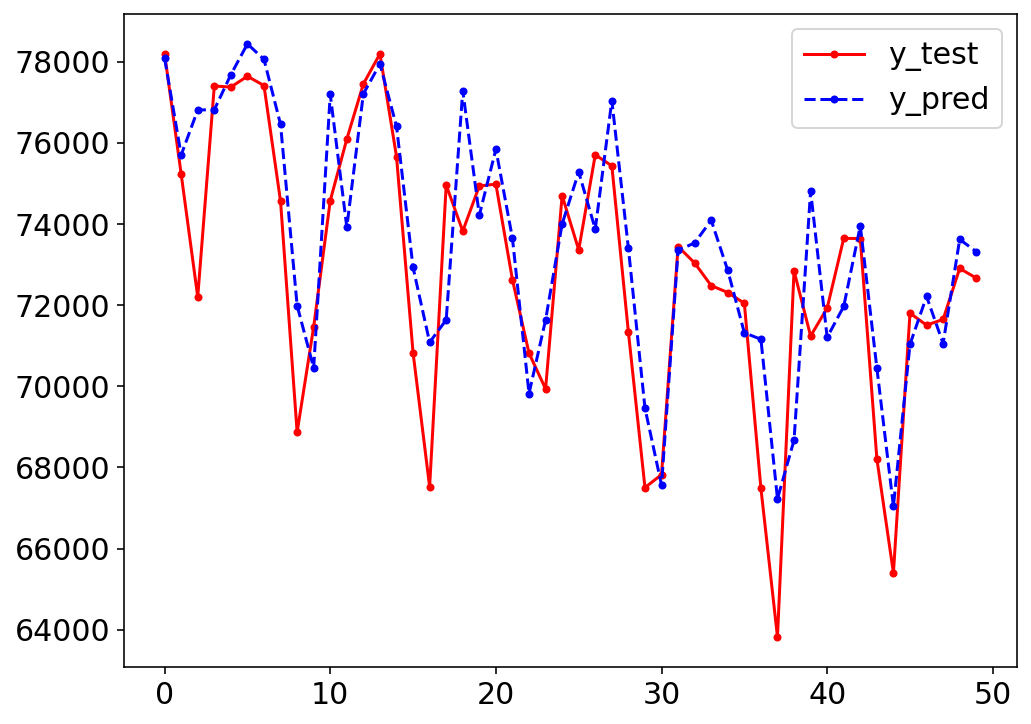

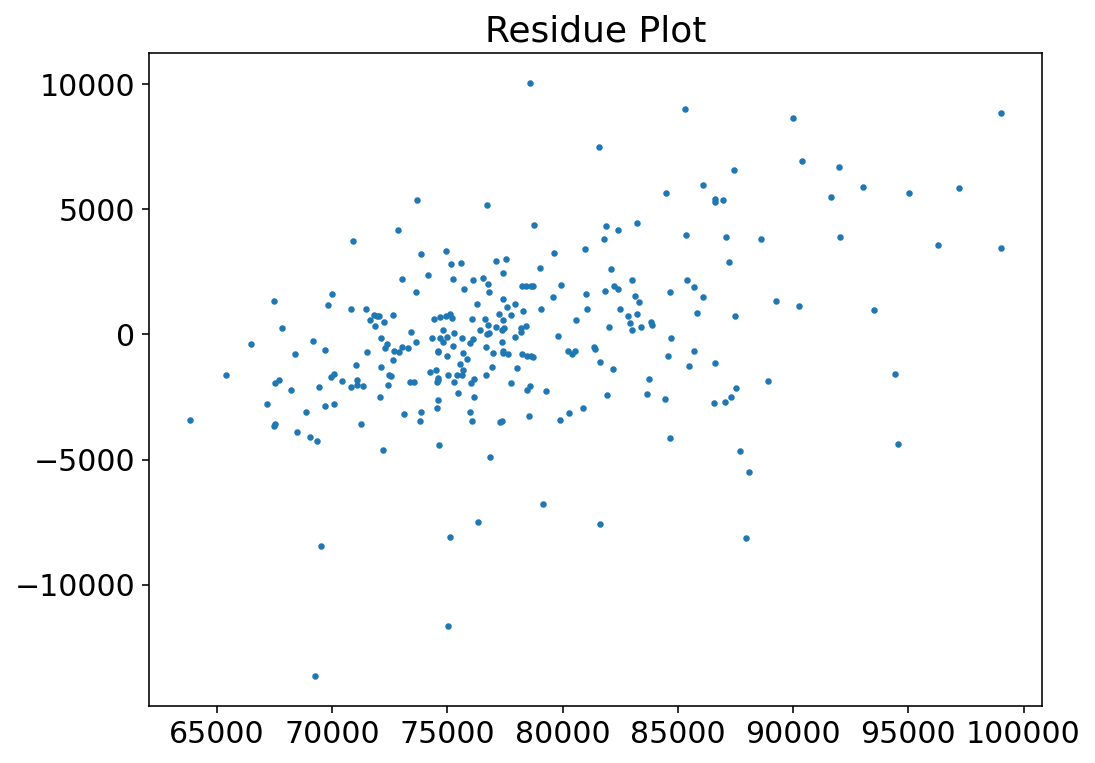

In [223]:
plot_reg_result(y_test, y_pred)

- 모델과 데이터를 주고 학습 수행후 성능을 평가하는 함수
- 디폴트로 shuffle=False 로 설정함 (시계열 데이터 이므로 과거 데이터로만 학습)

In [224]:
def model_run(model, X, y, shuffle=False):
    X_train, X_test, y_train, y_test = train_test_split(X, y, 
                shuffle=shuffle, random_state=9)
    model.fit(X_train, y_train) 
    return model.score(X_test, y_test).round(4)

- 동작 확인

In [118]:
y = df['y+1']
model_run(lin, X, y, shuffle=False)

0.7705

In [119]:
y = df['y+2']
model_run(lin, X, y, shuffle=False)

0.5955

### 선형, 랜덤포레스트, 부스팅 비교

In [120]:
rfr = RandomForestRegressor()
lgbm_r = LGBMRegressor()

res = []
for model in [lin, rfr, lgbm_r]:
    for i in range(1,4):
        y = df['y+'+str(i)]
        r2 = model_run(model, X, y, shuffle=False)
        res.append((model, i, r2))
res

[(LinearRegression(), 1, 0.7705),
 (LinearRegression(), 2, 0.5955),
 (LinearRegression(), 3, 0.5466),
 (RandomForestRegressor(), 1, 0.7454),
 (RandomForestRegressor(), 2, 0.5851),
 (RandomForestRegressor(), 3, 0.5143),
 (LGBMRegressor(), 1, 0.7618),
 (LGBMRegressor(), 2, 0.5858),
 (LGBMRegressor(), 3, 0.4781)]

### 랜덤 포레스트 다중 예측
- 랜덤 포레스트는 한번에 여러개의 y 값을 예측하는 모델을 지원한다
- 아래는 y에 3개의 값을 예측하도록 했다

In [123]:
y = df[['y+1', 'y+2', 'y+3']]
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                        shuffle=False, random_state=9)
rfr.fit(X_train, y_train) 
y_pred = rfr.predict(X_test)
r2_score(y_test, y_pred, multioutput='raw_values')

array([0.7233885 , 0.56579157, 0.48712559])

## 기타 특성 추가
- 이동평균, 이동분산, 최대-최소 차이, 평활화(ewma: Exponentially-weighted moving average) 등 특성을 추가할 수 있다

In [126]:
# 과거 5일간의 평균치를 컬럼에 추가
X2= X.copy()
X2["5-mean"] = X2.load.rolling(5,min_periods=1).mean()
X2[:5]

,load,load-1,load-10,load-11,load-12,load-13,load-14,load-15,load-2,load-3,load-4,load-5,load-6,load-7,load-8,load-9,temp,temp-1,5-mean
timestamp,,,,,,,,,,,,,,,,,,,
2012-01-16,91228.0,88319.0,85591.0,88096.0,92168.0,87887.0,76841.0,71562.0,84300.0,83503.0,84824.0,85021.0,85158.0,85818.0,77767.0,76869.0,12.180556,3.527778,91228.000000
2012-01-17,83799.0,91228.0,76869.0,85591.0,88096.0,92168.0,87887.0,76841.0,88319.0,84300.0,83503.0,84824.0,85021.0,85158.0,85818.0,77767.0,33.138889,12.180556,87513.500000
2012-01-18,84192.0,83799.0,77767.0,76869.0,85591.0,88096.0,92168.0,87887.0,91228.0,88319.0,84300.0,83503.0,84824.0,85021.0,85158.0,85818.0,28.263889,33.138889,86406.333333
2012-01-19,90190.0,84192.0,85818.0,77767.0,76869.0,85591.0,88096.0,92168.0,83799.0,91228.0,88319.0,84300.0,83503.0,84824.0,85021.0,85158.0,16.986111,28.263889,87352.250000
2012-01-20,87129.0,90190.0,85158.0,85818.0,77767.0,76869.0,85591.0,88096.0,84192.0,83799.0,91228.0,88319.0,84300.0,83503.0,84824.0,85021.0,19.791667,16.986111,87307.600000


- 다양한 특성 추가 예시
- ema에 지수형 가중값을 구한다
- min_periods=1 의 의미는 필요한 갯수가 되지 않더라도, 한개라도 평균 등을 계산하라는 뜻임 (초기 값들을 버리지 않기 위함)

In [225]:
X2["20-mean"] = X2.load.rolling(20,min_periods=1).mean()
X2["10-std"] = X2.load.rolling(10, min_periods=1).std().fillna(0)
X2['5EWMA'] = X2.load.ewm(span=5).mean()
X2["5-max"] = X2.load.rolling(5, min_periods=1).max()
X2["5-min"] = X2.load.rolling(5, min_periods=1).min()
X2["5-peak-difference"] = X2.load.rolling(5, min_periods=1).max()-X2.load.rolling(5, min_periods=1).min()
X2[:3]

,load,load-1,load-10,load-11,load-12,load-13,load-14,load-15,load-2,load-3,...,load-9,temp,temp-1,5-mean,20-mean,10-std,5EWMA,5-max,5-min,5-peak-difference
timestamp,,,,,,,,,,,,,,,,,,,,,
2012-01-16,91228.0,88319.0,85591.0,88096.0,92168.0,87887.0,76841.0,71562.0,84300.0,83503.0,...,76869.0,12.180556,3.527778,91228.000000,91228.000000,0.000000,91228.000000,91228.0,91228.0,0.0
2012-01-17,83799.0,91228.0,76869.0,85591.0,88096.0,92168.0,87887.0,76841.0,88319.0,84300.0,...,77767.0,33.138889,12.180556,87513.500000,87513.500000,5253.096277,86770.600000,91228.0,83799.0,7429.0
2012-01-18,84192.0,83799.0,77767.0,76869.0,85591.0,88096.0,92168.0,87887.0,91228.0,88319.0,...,85818.0,28.263889,33.138889,86406.333333,86406.333333,4180.306727,85549.157895,91228.0,83799.0,7429.0


In [226]:
# X2를 사용하는 경우의 성능 비교 (아래에서 X2를 사용함)
res = []
for model in [lin, rfr, lgbm_r]:
    for i in range(1,4):
        y = df['y+'+str(i)]
        r2 = model_run(model, X2, y, shuffle=False)
        res.append((model, i, r2))
res

[(LinearRegression(), 1, 0.772),
 (LinearRegression(), 2, 0.5964),
 (LinearRegression(), 3, 0.5427),
 (RandomForestRegressor(), 1, 0.7375),
 (RandomForestRegressor(), 2, 0.5662),
 (RandomForestRegressor(), 3, 0.4934),
 (LGBMRegressor(), 1, 0.7542),
 (LGBMRegressor(), 2, 0.5495),
 (LGBMRegressor(), 3, 0.4588)]

# 정답

## (연습) 윈도우가 7일 경우의 split_seq()를 수행해보시오

In [177]:
sequence = [1,2,3,4,5,6,7,8,9,10,11,12,13]
split_seq(sequence, 5)

(array([[ 1,  2,  3,  4,  5],
        [ 2,  3,  4,  5,  6],
        [ 3,  4,  5,  6,  7],
        [ 4,  5,  6,  7,  8],
        [ 5,  6,  7,  8,  9],
        [ 6,  7,  8,  9, 10],
        [ 7,  8,  9, 10, 11],
        [ 8,  9, 10, 11, 12]]),
 array([ 6,  7,  8,  9, 10, 11, 12, 13]))

## (연습) 선형 예측 모델에서 과거 5일 및 15일을 사용할 때 각각의 성능을 구하시오

In [183]:
x_train, y_train = split_seq(train_data, 5)
x_test, y_test = split_seq(test_data, 5)
lin.fit(x_train, y_train) 
lin.score(x_test, y_test)

0.9333219796700054

In [184]:
x_train, y_train = split_seq(train_data, 15)
x_test, y_test = split_seq(test_data, 15)
lin.fit(x_train, y_train) 
lin.score(x_test, y_test)

0.9362455889020727

## (연습) 선형 예측 모델에서 과거 몇 개를 예측에 사용하면 성능이 가장 좋은지 최적 값을 찾으시오

- 힌트 n_steps 값을 바꾸어 본다 (1 ~ 180 일)
- 가장 성능이 좋을 때의 회귀 성능을 확인하시오

In [185]:
N = 180
result = []

for n_steps in range(1,N+1): 
    x_train, y_train = split_seq(train_data, n_steps)
    x_test, y_test = split_seq(test_data, n_steps)
    lin.fit(x_train, y_train) 
    result.append((n_steps, lin.score(x_test, y_test)))
                  
result[:10]

[(1, 0.9278711483333497),
 (2, 0.9284242771093589),
 (3, 0.9318384895047028),
 (4, 0.933021894827026),
 (5, 0.9333219796700054),
 (6, 0.9344556836268625),
 (7, 0.9349083866978511),
 (8, 0.935610096333157),
 (9, 0.9355260563224183),
 (10, 0.9359804760059094)]

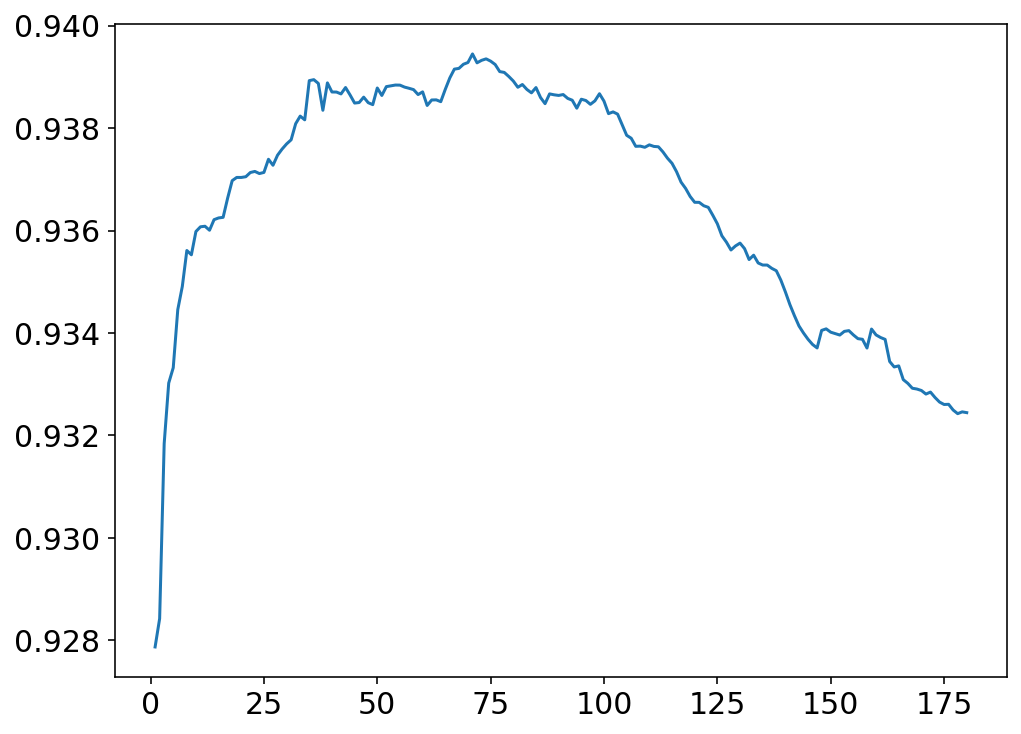

In [186]:
result = np.array(result)
plt.plot(result[:,0], result[:,1])

In [187]:
x_train, y_train = split_seq(train_data, 30)
x_test, y_test = split_seq(test_data, 30)
lin.fit(x_train, y_train) 
y_pred = lin.predict(x_test)
show_reg_result(y_test, y_pred)

Max Error:  8.237
Mean Absolute Error:  1.481
Root Mean Squared Error:  1.912
R-Squared:  0.938


## (연습) 최적의 윈도우 값을 찾는 위의 예에서 결과를 리스트가 아니라 딕셔너리에 담아보시오

- 딕셔너리에 값을 담을 때는 key를 인자로 사용하고 값을 배정하면 된다
- 결과를 그래프로 그려보시오

In [196]:
# 리스트가 아니라 딕서너리에 결과를 담는 방법
result = {}
N = 20
for i in range(1,N+1): 
    n_steps=i
    x_test, y_test = split_seq(test_data, n_steps)
    y_pred = average_model(x_test)
    result[i]= r2_score(y_test, y_pred).round(4)

In [197]:
result

{1: 0.9266,
 2: 0.9166,
 3: 0.9113,
 4: 0.9074,
 5: 0.9037,
 6: 0.901,
 7: 0.8991,
 8: 0.8982,
 9: 0.8971,
 10: 0.896,
 11: 0.8948,
 12: 0.8932,
 13: 0.8913,
 14: 0.8897,
 15: 0.888,
 16: 0.8861,
 17: 0.8841,
 18: 0.8812,
 19: 0.8778,
 20: 0.8741}

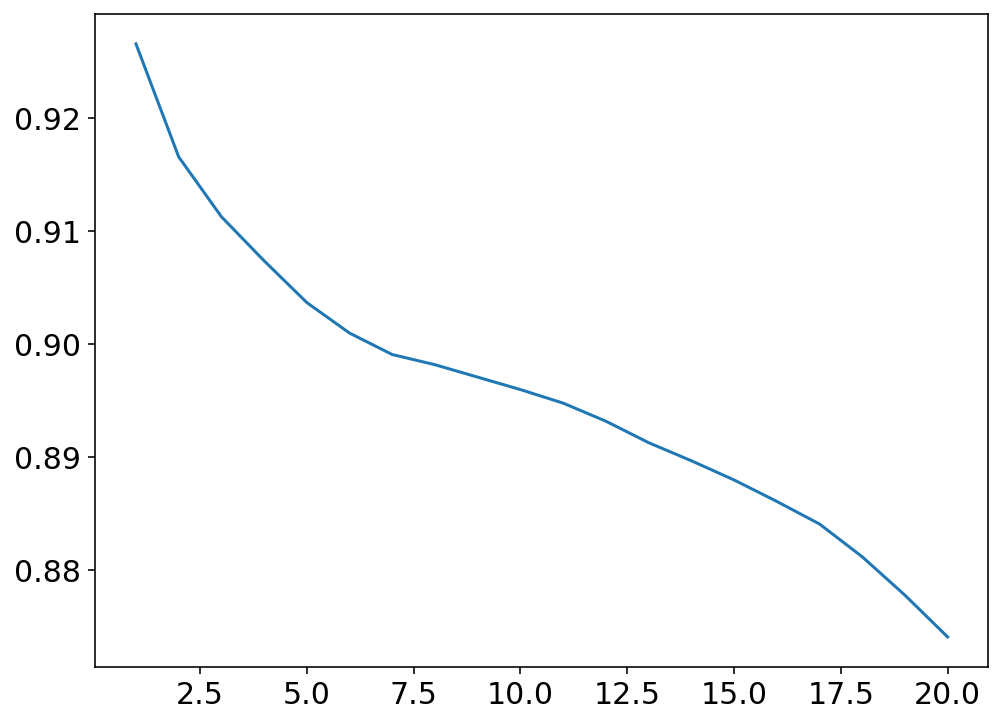

In [198]:
plt.plot(result.keys(),result.values())

In [199]:
# 최대값을 들어있는 항목의 키 찾기
# 최소값 찾는 함수는 min()
max(result, key=result.get)

1

## (연습) LightGBM 모델을 사용하고 윈도우 크기를 바꾸어 성능을 비교하시오

- lightgbm을 먼저 설치해야 한다 (!pip install lightgbm)
- 모델로 LGBMRegressor()를 사용한다

max R2:  0.735


Text(0.5, 1.0, 'R2 vs window size(LightGBM)')

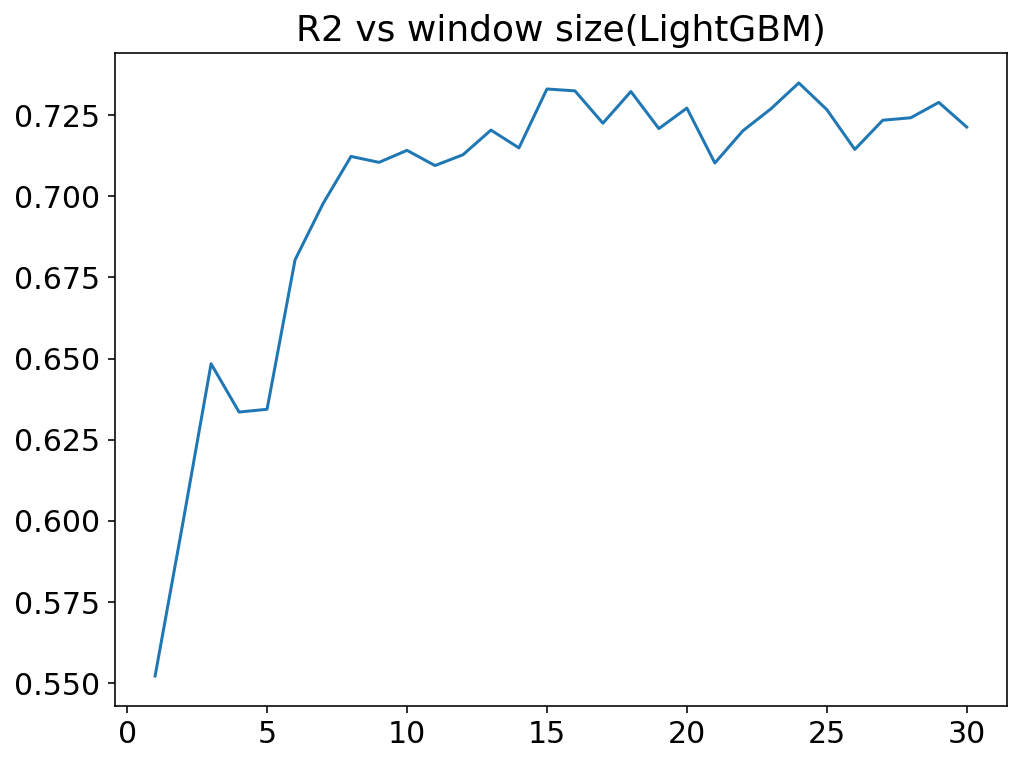

In [209]:
lgbm_r = LGBMRegressor()
N = 30
result = []

for n_steps in range(1,N+1): 
    r2 = split_seq_fit(lgbm_r, train_data, test_data, n_steps)
    result.append((n_steps, r2))
                  
result = np.array(result)
print("max R2: ", result[:,1].max().round(3))

plt.plot(result[:,0], result[:,1])
plt.title("R2 vs window size(LightGBM)")